# Predicting the Success or Failure of Tech Projects on Kickstarter

Crowdfunding platforms like Kickstarter have provided individuals and organizations with an alternative means of raising funds for their projects. However, not all projects on Kickstarter are successful in reaching their funding goals. In this research, our objective is to determine if we can predict the success or failure of technology projects on Kickstarter based on the project's characteristics and funding details.

In [1]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.common.by import By
import time
import json
import csv
import concurrent.futures
import random
import psutil
from selenium.webdriver.common.proxy import Proxy, ProxyType
%matplotlib notebook

### Data Acquisition Challenges and Solutions


During the data acquisition process, we encountered challenges that required innovative solutions.One of the challenges was <b>the website blocking our automated tools</b>, which hindered the data gathering process. To overcome this obstacle, <b>we decided to purchase a webShare proxy service, which provided a different IP address for each driver launched (approximately 6000 drivers).</b> This allowed us to bypass the website blocks and collect the necessary data from Kickstarter.


In [2]:
def initialize_driver():
    
    PROXY = "p.webshare.io:9999"
    webdriver.DesiredCapabilities.FIREFOX['proxy'] = {
    "httpProxy": PROXY,
    "sslProxy": PROXY,
    "proxyType": "MANUAL",
    }
    
    firefox_driver_path = "/Users/reembeniluz/Downloads/geckodriver"  # Replace with the actual path to the GeckoDriver executable
    options = Options()
    options.add_argument('-headless')
    options.add_argument("--private")
    driver = webdriver.Firefox(service=Service(firefox_driver_path), options=options)
    print("Driver was created")
    return driver

As a consequence of the website blocking our access due to the use of automated tools, we used proxy servers and launched a separate driver for each attempt to access the website.

In [3]:
def scrape_page(url):
    driver = initialize_driver()
    driver.get(url)
    time.sleep(random.randint(2, 4))
    links = []
    extract_project_links(driver, links)
    driver.quit()
    return links

Another challenge we faced was the complexity of exploring the elements on the webpage, as it was a dynamic page. To overcome this issue, we employed JavaScript injections to capture the required elements

In [4]:
def extract_project_links(driver, links):
    page_links = driver.execute_script("""
        const elements = document.querySelectorAll('div.relative.self-start a[href].block.img-placeholder.w100p');
        const filteredLinks = [];
        elements.forEach(element => {
            const href = element.getAttribute('href');
            if (!href.includes('ref=recommendation-no-result-discoverpage')) {
                filteredLinks.push(href);
            }
        });
        return filteredLinks;
    """)
    links.extend(page_links)

By implementing multi-threaded programming techniques, we were able to expedite the entire process and achieve a remarkable reduction in time. Specifically, we reduced the time required by an impressive 95%, shortening it from 60 hours to just 3 hours.

In [5]:

def projects_links_list_from_website(url, start_page, end_page, links,seed):
    page_seed = seed
    for seed_count in range(1,2):
        page_urls = [url.replace(f'page={start_page}', f'page={page}') for page in range(start_page, end_page+1)]

        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            futures = [executor.submit(scrape_page, page_url) for page_url in page_urls]

            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                print(result)
                links.extend(result)
                future.done()

            url = url.replace(f'seed={page_seed}', f'seed={page_seed+1}')
            page_seed += 1
        for future in futures:
            future.result()
    return 


# Dataset Overview


The dataset includes columns such as Project Link, Project Name, Currency, Location, Parent Category, Category Name, Is Project We Love, Percent Funded, Goal Amount, Pledged Amount, Duration, Description Length, Image Count, Video Count, Risk Desc Count, Days Left, and Success. These columns provide information about the projects.

In [6]:
def scrape_project_data(link,driver):
    driver.get(link)
    time.sleep(10)
    try:
        element = driver.find_element(By.XPATH, '//*[@id="react-project-header"]')
        days_left_element = driver.find_element(By.XPATH, '/html/body/main/div/div/div[1]/div/div[1]/div[1]/div[2]/div[2]/div[3]/div/div/span[1]')
        data_initial = element.get_attribute("data-initial")
        json_data = json.loads(data_initial)
        project_name = json_data['project']['name']
        project_link = link
        currency = json_data['project']['currency']
        location = json_data['project']['location']['displayableName']
        try:
            parent_category = json_data['project']['category']['parentCategory']['name']
        except:
            parent_category = 'none'
        category_name = json_data['project']['category']['name']
        is_project_we_love = json_data['project']['isProjectWeLove']
        percent_funded = json_data['project']['percentFunded']
        goal_amount = json_data['project']['goal']['amount']
        pledged_amount = json_data['project']['pledged']['amount']
        duration = json_data['project']['duration']
        description_length = len(json_data['project']['description'])
        video_elements = driver.find_elements(By.TAG_NAME, "video")
        video_count = len(video_elements)
        image_elements = driver.find_elements(By.TAG_NAME, "img")
        image_count = len(image_elements)
        days_left = days_left_element.text

        try:
            riskField = driver.find_element(By.XPATH, '//*[@id="risks-and-challenges"]/p')
            riskDescLength = len(riskField.text)
        except:
            riskDescLength = 0
            
        project_info = {
        "Project Link":project_link,
        "Project Name": project_name,
        "Currency": currency,
        "Location": location,
        "Parent Category": parent_category,
        "Category Name": category_name,
        "Is Project We Love": is_project_we_love,
        "Percent Funded": percent_funded,
        "Goal Amount": goal_amount,
        "Pledged Amount": pledged_amount,
        "Duration": duration,
        "Description Length": description_length,
        "Image Count": image_count,
        "Video Count": video_count,
        "Risk Desc Count": riskDescLength,
        "Days Left":days_left
    }
    except:
        print("problem with link", link)


    return project_info

In [7]:
def projects_data_from_links(links,project_data_dic):
    counter = 1

    def scrape_project_data_wrapper(link):
        driver = initialize_driver()
        try:
            return scrape_project_data(link,driver)
        finally:
            print("Driver Quited")
            driver.quit()
            time.sleep(20)
            
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(scrape_project_data_wrapper, link) for link in links]
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                project_data_dic.append(result)
                print('finished with project:', counter)
                counter += 1
            except:
                print('skipping link')

    return 


In [8]:
def create_csv_table(data, filename):
    fieldnames = [
        "Project Name",
        "Project Link",
        "Parent Category",
        "Category Name",
        "Location",
        "Currency",
        "Goal Amount",
        "Pledged Amount",
        "Percent Funded",
        "Duration",
        "Days Left",
        "Description Length",
        "Risk Desc Count",
        "Is Project We Love",
        "Image Count",
        "Video Count"
    ]
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

In [9]:
def load_list():
    with open("ProjectsLinks.txt", "r") as file:
        # Read the content of the file and store each line as an element in the list
        links = file.readlines()
        # Remove trailing newline characters from each line
        links = [link.strip() for link in links]
    return links

In [10]:
def save_urls_to_file(url_list, filename):
    with open(filename, 'w') as file:
        for url in url_list:
            file.write(url + '\n')
    print(f"URLs saved to '{filename}' successfully.")


In [11]:
def load_csv_into_dict(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

In [12]:
def remove_duplicate_dicts(data):
    unique_data = []
    unique_project_links = set()
    for row in data:
        project_link = row['Project Link']
        if project_link not in unique_project_links:
            unique_data.append(row)
            unique_project_links.add(project_link)
    return unique_data

In [ ]:
projectDict = load_csv_into_dict('projects_table_data_final.csv')
unique_data = remove_duplicate_dicts(projectDict)
create_csv_table(unique_data,'projects_table_data_final.csv')
links=[]
project_data_dic = []
url = "https://www.kickstarter.com/discover/advanced?woe_id=Earth&sort=magic&ref=discovery_overlay&seed=2810541&page=1"
projects_links_list_from_website(url,1,200,links,2810541)

In [ ]:
projects_data_from_links(links,project_data_dic)
create_csv_table(project_data_dic,'projects_table_data.csv')
print('table was created successfuly')

# EDA

Exploratory Data Analysis (EDA) is a fundamental process in predicting the success or failure of tech projects on Kickstarter. By examining project characteristics and funding details, EDA uncovers patterns and insights within the dataset. It helps identify key factors influencing project outcomes, such as the percentage funded, goal amount, duration, and description length. Through visualizations and statistical analysis, EDA enables researchers to gain a comprehensive understanding of the data, assisting in the development of accurate prediction models.

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [14]:
def load_csv_to_dataframe():
    return pd.read_csv("/Users/reembeniluz/DataScienceProj/projects_table_data_final.csv")

To resolve the confusion caused by having countries within the USA listed in the location column during data analysis, a function was created to convert such cells to only contain "USA". The function ensures that the data is consistent and easier to interpret.

In [15]:
def clean_location_col(df):
    state_shortcuts = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}
    df["Location"] = df["Location"].apply(lambda x: 'USA' if any(state in x.split(', ') for state in state_shortcuts.values()) else x.split(', ')[-1].strip())
    return df

In [16]:
def classify_success_col(df):
    df['Success'] = 0
    df.loc[df['Percent Funded'] >= 100, 'Success'] = 1

In [17]:
def boolean_to_numbers(df):
    df['Is Project We Love'] = df['Is Project We Love'].map({False: 0, True: 1})

In [18]:
def targetCol_success_compare(target_col, top_n=20):
    success = df.groupby(target_col)['Success'].mean().sort_values(ascending=False)
    count = df.groupby(target_col)['Success'].count().loc[success.index]
    top_n_categories = success[(success < 1) | (count >= 5)][:top_n]

    fig = px.bar(top_n_categories, x=top_n_categories.index, y=top_n_categories.values,
                 color=top_n_categories.index, color_discrete_sequence=["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"])

    fig.update_layout(
        title='Success Rate by ' + target_col,
        xaxis=dict(title=target_col),
        yaxis=dict(title='Success Rate'),
        xaxis_tickangle=-45,
        showlegend=False
    )

    fig.show()

In [19]:
def create_heatMap():
    colors = ["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]
    columns = ['Description Length', 'Goal Amount', 'Duration', 'Risk Desc Count', 'Image Count', 'Video Count', 'Is Project We Love', 'Success']

    # Add the 'Location' column count to the dataframe
    location_count = df['Location'].value_counts().reset_index()
    location_count.columns = ['Location', 'Country']
    df_with_location_count = df.merge(location_count, on='Location', how='left')

    # Add the 'Count' column to the columns list
    columns_with_location_count = columns + ['Country']

    # Calculate the correlation matrix
    corr_matrix = df_with_location_count[columns_with_location_count].corr()

    fig = px.imshow(corr_matrix, color_continuous_scale=colors)
    fig.update_layout(
        title='Correlation Heatmap',
        xaxis=dict(title='Columns'),
        yaxis=dict(title='Columns'),
        showlegend=False
    )

    fig.show()

In [20]:
def create_target_box_graph(target):
    colors = ["#63bff0","#e14b31"]
    fig = px.box(df, x='Success', y=target, color='Success', color_discrete_sequence=colors)

    fig.update_layout(
        title= target + ' Distribution by Project Success',
        xaxis=dict(title='Project Success'),
        yaxis=dict(title=target+'Count'),
        showlegend=False
    )

    fig.show()

In [21]:
def create_count_by_category_graph():
    colors = ["#22a7f0", "#63bff0", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31"]

    counts = df['Parent Category'].value_counts().reset_index()
    counts.columns = ['Parent Category', 'Count']

    fig = px.bar(counts, x='Parent Category', y='Count', color='Parent Category', color_discrete_sequence=colors)

    fig.update_layout(
        title='Count of Projects by Parent Category',
        xaxis=dict(title='Parent Category'),
        yaxis=dict(title='Count'),
        showlegend=False,
    )

    fig.show()

In [22]:
def create_category_success_distribuition():
    success_by_category = df.groupby(['Parent Category', 'Success']).size().unstack()
    success_by_category = success_by_category.div(success_by_category.sum(axis=1), axis=0) * 100

    colors = ["#de6e56","#63bff0"]
    fig = px.bar(success_by_category, barmode='stack', color_discrete_sequence=colors)

    fig.update_layout(
        title='Distribution of Project Success by Parent Category',
        xaxis=dict(title='Parent Category'),
        yaxis=dict(title='Percentage'),
        legend=dict(title='Success', x=1.0, y=1.0),
        showlegend=True,
        xaxis_tickangle=-45
    )

    fig.show()

In [23]:
def create_category_love_distribution():
    success_by_category = df.groupby(['Parent Category', 'Is Project We Love']).size().unstack()
    success_by_category = success_by_category.div(success_by_category.sum(axis=1), axis=0) * 100

    colors = ["#de6e56","#63bff0"]
    fig = px.bar(success_by_category, barmode='stack', color_discrete_sequence=colors)

    fig.update_layout(
        title='Distribution of Project Success by Is Project We Love',
        xaxis=dict(title='Is Project We Love'),
        yaxis=dict(title='Percentage'),
        legend=dict(title='Success', x=1.0, y=1.0),
        showlegend=True,
        xaxis_tickangle=-45
    )

    fig.show()

In [24]:
def create_low_goal_percent_funded_graph():
    low_goal_df = df[df['Goal Amount'] < df['Goal Amount'].median()]
    success_by_category = low_goal_df.groupby('Parent Category')['Success'].mean().reset_index()
    median_values = low_goal_df.groupby('Parent Category')['Goal Amount'].median().reset_index()
    success_by_category['Median Goal Amount'] = median_values['Goal Amount']

    fig = px.bar(success_by_category, x='Parent Category', y='Success',
                 title="Success Rate by Parent Category (Low Goal Amount)",
                 labels={'Parent Category': 'Parent Category', 'Success': 'Success Rate'},
                 color_discrete_sequence=['#63bff0'])

    for i, row in success_by_category.iterrows():
        fig.add_annotation(
            x=row['Parent Category'],
            y=row['Success'],
            text=f"{row['Median Goal Amount']}",
            showarrow=False,
            font=dict(color='black'),
            yshift=10
        )

    fig.update_layout(showlegend=False)
    fig.show()


In [25]:
def create_high_goal_percent_funded_graph():
    high_goal_df = df[df['Goal Amount'] > df['Goal Amount'].median()]
    success_by_category = high_goal_df.groupby('Parent Category')['Success'].mean().reset_index()
    median_by_category = high_goal_df.groupby('Parent Category')['Goal Amount'].median().reset_index()
    success_by_category['Median Goal Amount'] = median_by_category['Goal Amount']
    fig = px.bar(success_by_category, x='Parent Category', y='Success',
                 title="Success Rate by Parent Category (High Goal Amount)",
                 labels={'Parent Category': 'Parent Category', 'Success': 'Success Rate'},
                 color_discrete_sequence=['#63bff0'])

    for i, row in success_by_category.iterrows():
        fig.add_annotation(
            x=row['Parent Category'],
            y=row['Success'],
            text=f"{row['Median Goal Amount']}",
            showarrow=False,
            font=dict(color='black'),
            yshift=10
        )

    fig.update_layout(showlegend=False)
    fig.show()

In [26]:
df = load_csv_to_dataframe()

# Calculate the IQR for 'Goal Amount' column
goal_amount_iqr = np.percentile(df['Goal Amount'], 75) - np.percentile(df['Goal Amount'], 25)
# Define the upper and lower bounds for outliers
lower_bound = np.percentile(df['Goal Amount'], 25) - 1.5 * goal_amount_iqr
upper_bound = np.percentile(df['Goal Amount'], 75) + 1.5 * goal_amount_iqr
# Filter the dataset to include only the rows within the IQR bounds
df = df[(df['Goal Amount'] >= lower_bound) & (df['Goal Amount'] <= upper_bound)]

goal_amount_iqr = np.percentile(df['Duration'], 75) - np.percentile(df['Duration'], 25)
# Define the upper and lower bounds for outliers
lower_bound = np.percentile(df['Duration'], 25) - 1.5 * goal_amount_iqr
upper_bound = np.percentile(df['Duration'], 75) + 1.5 * goal_amount_iqr
# Filter the dataset to include only the rows within the IQR bounds
df = df[(df['Duration'] >= lower_bound) & (df['Duration'] <= upper_bound)]
clean_location_col(df)
classify_success_col(df)
boolean_to_numbers(df)
df.to_csv('handled Table.csv', index=False)


# Visualisation:

This graph visualizes the count of projects by their parent category, showcasing the distribution and relative frequency of projects across different categories:

In [27]:
create_count_by_category_graph()

This graph represents the distribution of project success across different parent categories, showcasing the percentage of successful projects compared to unsuccessful ones:

In [28]:
create_category_success_distribuition()

This graph represents the distribution of project success based on whether the project is labeled as "Project We Love":

In [29]:
create_category_love_distribution()

The following graphs represent the success rate of different categories based on a specified target column:

In [30]:
targetCol_success_compare("Location")

In [31]:
targetCol_success_compare("Currency")

In [32]:
targetCol_success_compare("Parent Category")

This is a correlation heatmap for selected columns in the DataFrame:

In [33]:
create_heatMap()

The following box plots compare the distribution of a specified target variable based on project success:

In [34]:
create_target_box_graph('Image Count')

In [35]:
create_target_box_graph('Video Count')

In [36]:
create_target_box_graph('Description Length')

In [37]:
create_target_box_graph('Risk Desc Count')

The following graph represnets the success rate of projects within a specific category when their goal amounts are below the median goal amount:

In [38]:
create_low_goal_percent_funded_graph()

The following graph represnets the success rate of projects within a specific category when their goal amounts are above the median goal amount:

In [39]:
create_high_goal_percent_funded_graph()

# Machine Learning part

To predict the success or failure of tech projects on Kickstarter, we employed two machine learning models: linear regression and decision trees.


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.tree import plot_tree

In [41]:
def load_handled_dataset():
    return pd.read_csv("/Users/reembeniluz/DataScienceProj/handled Table.csv")

# Linear regression

Linear regression is a widely used statistical model that aims to establish a linear relationship between the dependent variable (in our case, project success) and one or more independent variables (project characteristics and funding details). By fitting a regression line to the data, we can make predictions based on the observed values of the independent variables.
In our analysis, we applied linear regression to determine the impact of various project attributes on the likelihood of success or failure. By examining the coefficients associated with each independent variable, we gained insights into the relative importance of different factors in predicting project outcomes

In [42]:
def run_linear_regression_model():
    selected_categories = ['Comics', 'Fashion', 'Photography', 'Film & Video', 'Art', 'none', 'Music',
                           'Publishing', 'Games', 'Technology', 'Food', 'Theater', 'Design', 'Crafts',
                           'Journalism', 'Dance']
    category_markers = {
        'Comics': {'marker': 's'},
        'Fashion': {'marker': 'o'},
        'Photography': {'marker': 'v'},
        'Film & Video': {'marker': 'p'},
        'Art': {'marker': 'h'},
        'none': {'marker': 'x'},
        'Music': {'marker': 'D'},
        'Publishing': {'marker': 's'},
        'Games': {'marker': 'o'},
        'Technology': {'marker': 'v'},
        'Food': {'marker': 'p'},
        'Theater': {'marker': 'h'},
        'Design': {'marker': 'x'},
        'Crafts': {'marker': 'D'},
        'Journalism': {'marker': 's'},
        'Dance': {'marker': 'o'}
    }

    # Initialize variables for TSS and SSE
    tss = 0
    sse = 0

    # Create a new plot for all categories combined
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over each Parent Category
    for category in selected_categories:
        # Filter the data for the specific Parent Category and Pledged Amount less than 10000
        category_data = data[(data['Parent Category'] == category) & (data['Pledged Amount'] < 1000) & (data['Goal Amount'] < 30000)]

        # Check if there are any data points for the current category
        if len(category_data) > 0:
            # Scatter plot with different colors and marker shapes
            ax.scatter(category_data[category_data['Success'] == 1]['Goal Amount'],
                       category_data[category_data['Success'] == 1]['Pledged Amount'],
                       color='blue', marker='*', s=100)

            ax.scatter(category_data[category_data['Success'] == 0]['Goal Amount'],
                       category_data[category_data['Success'] == 0]['Pledged Amount'],
                       color='red', marker=category_markers[category]['marker'])

             # Perform linear regression
        model = LinearRegression()
        X = category_data['Goal Amount'].values.reshape(-1, 1)
        y = category_data['Percent Funded']
        model.fit(X, y)

        # Get the coefficient and intercept
        coefficient = model.coef_[0]
        intercept = model.intercept_

        # Calculate predicted values
        y_pred = model.predict(X)

        # Calculate squared difference between actual and predicted values
        squared_diff = (y - y_pred) ** 2

        # Calculate SSE for the "Comics" category
        sse = squared_diff.sum()

        # Calculate the mean of the Percent Funded values
        mean_percent_funded = np.mean(category_data['Percent Funded'])

        # Calculate the Total Sum of Squares (TSS)
        tss = np.sum((category_data['Percent Funded'] - mean_percent_funded) ** 2)

        # Calculate the coefficient of determination (R-squared)
        r_squared = 1 - (sse / tss)

        # Print the Parent Category, coefficient, intercept, SSE, and R-squared
        print(f'Parent Category: {category}')
        print(f'Coefficient: {coefficient}')
        print(f'Intercept: {intercept}')
        print(f'Sum of Squared Errors (SSE): {sse:.4f}')
        print(f'Coefficient of Determination (R-squared): {r_squared:.4f}')



    # Set the title and labels for the plot
    ax.set_title('Combined Categories - Goal Amount vs Pledged Amount (Pledged Amount < 10000)')
    ax.set_xlabel('Goal Amount')
    ax.set_ylabel('Pledged Amount')

    # Show the plot
    plt.tight_layout()
    plt.show()


# Decision trees

Decision trees are popular machine learning algorithms that can be used for both classification and regression tasks. These models create a hierarchical structure of decision nodes and leaf nodes, where each decision node represents a feature or attribute, and each leaf node represents a class label.
By constructing a decision tree based on our dataset, we aimed to identify the decision rules that best distinguish successful and failed tech projects on Kickstarter. The resulting tree can be used to make predictions for new projects by following the path from the root node to a leaf node, which corresponds to the predicted class label.

In [43]:
def run_decision_tree_model():
    # Separate features (X) and target variable (y)
    X = data[['Goal Amount', 'Duration']]
    y = data['Success']

    # Split the data into training and testing sets based on 'Goal Amount' and 'Duration'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a decision tree classifier with max_depth=3
    decision_tree = DecisionTreeClassifier(max_depth=3)

    # Fit the classifier to the training data
    decision_tree.fit(X_train, y_train)

    # Predict with the training data
    y_pred_train = decision_tree.predict(X_train)
    print('Accuracy on training data = ', metrics.accuracy_score(y_train, y_pred_train))

    # Predict with the test data
    y_pred = decision_tree.predict(X_test)
    print('Accuracy on test data = ', metrics.accuracy_score(y_test, y_pred))

    # Plot the decision tree
    plt.figure(figsize=(12, 6))
    plot_tree(decision_tree, feature_names=X.columns, class_names=['fail', 'success'], filled=True)
    plt.show()


In [44]:
def run_improved_decision_tree_model():
    # Separate features (X) and target variable (y)
    X = data[[ 'Duration','Is Project We Love','Image Count', 'Goal Amount']]
    y = data['Success']

    # Split the data into training and testing sets based on 'Goal Amount' and 'Duration'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a decision tree classifier with max_depth=3
    decision_tree = DecisionTreeClassifier(max_depth=4)

    # Fit the classifier to the training data
    decision_tree.fit(X_train, y_train)

    # Predict with the training data
    y_pred_train = decision_tree.predict(X_train)
    print('Accuracy on training data = ', metrics.accuracy_score(y_train, y_pred_train))

    # Predict with the test data
    y_pred = decision_tree.predict(X_test)
    print('Accuracy on test data = ', metrics.accuracy_score(y_test, y_pred))

    # Plot the decision tree
    plt.figure(figsize=(48, 24))
    plot_tree(decision_tree, feature_names=X.columns, class_names=['fail', 'success'], filled=True)
    plt.show()

In [45]:
data = load_handled_dataset();

לכתוב משהו על זה שהמודל לא נתן לנו את מה שרצינו לראות ולכן התמקדנו במודל השני

<IPython.core.display.Javascript object>


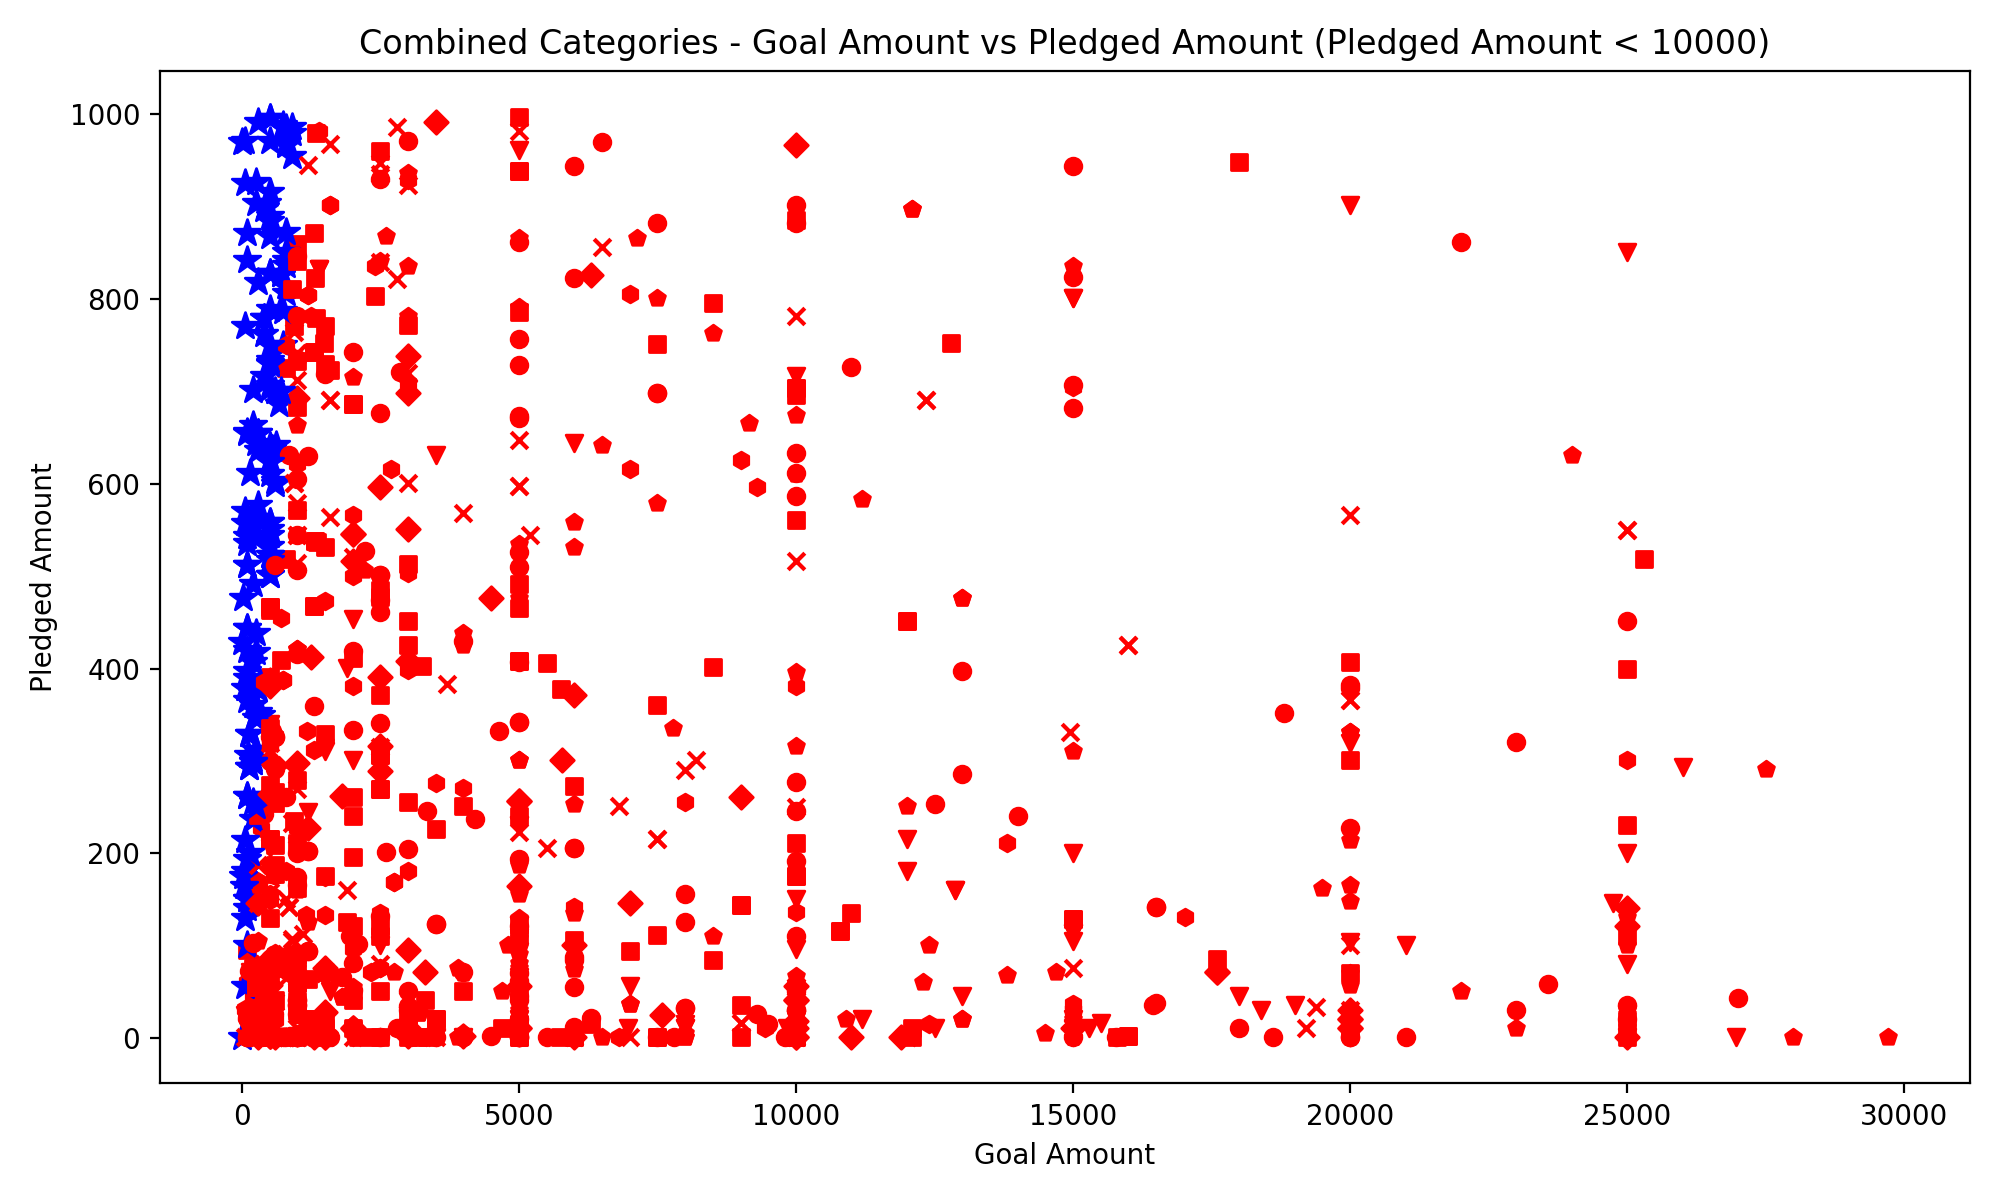

Parent Category: Comics
Coefficient: -0.006918380146883059
Intercept: 81.18684529725513
Sum of Squared Errors (SSE): 408432.3342
Coefficient of Determination (R-squared): 0.1310
Parent Category: Fashion
Coefficient: -0.003525607764395505
Intercept: 55.75985315305707
Sum of Squared Errors (SSE): 213599.5263
Coefficient of Determination (R-squared): 0.1588
Parent Category: Photography
Coefficient: -0.002062590285450352
Intercept: 37.992479592498874
Sum of Squared Errors (SSE): 8604.8909
Coefficient of Determination (R-squared): 0.2501
Parent Category: Film & Video
Coefficient: -0.0017430306215570682
Intercept: 26.751244554892597
Sum of Squared Errors (SSE): 108046.9717
Coefficient of Determination (R-squared): 0.1216
Parent Category: Art
Coefficient: -0.004925118779583882
Intercept: 62.570616930328
Sum of Squared Errors (SSE): 437839.4205
Coefficient of Determination (R-squared): 0.1192
Parent Category: none
Coefficient: -0.004252073042918847
Intercept: 41.05423152165654
Sum of Squared E

In [46]:
run_linear_regression_model();

לכתוב משהו על זה שהמודל עבד יפה ובחרנו לשפר אותו 

Accuracy on training data =  0.6545209176788124
Accuracy on test data =  0.6492805755395683


<IPython.core.display.Javascript object>


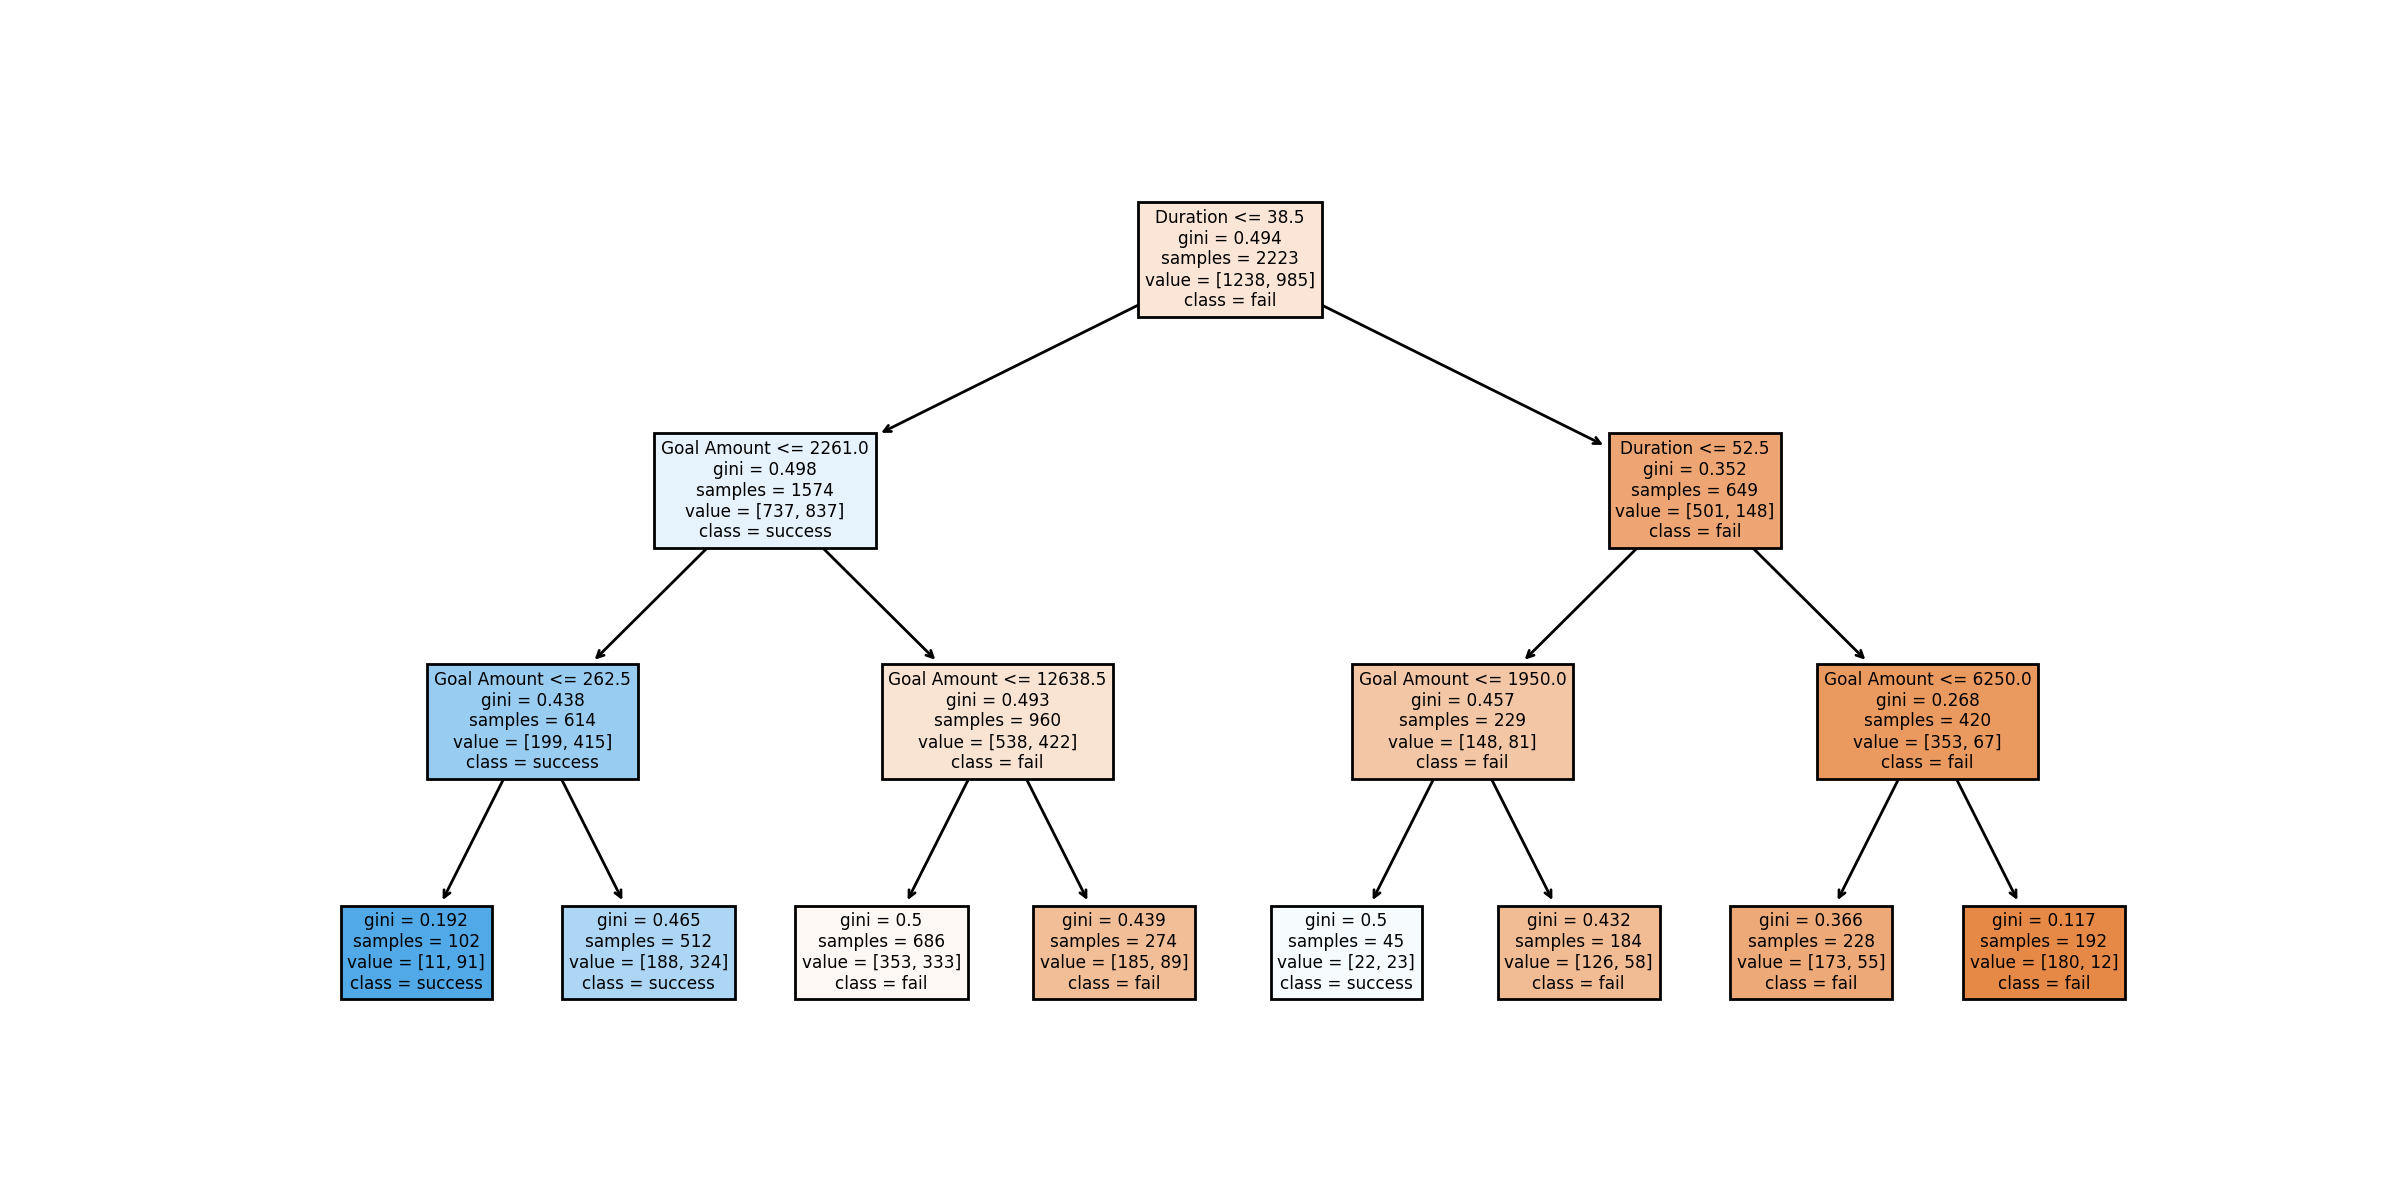

In [47]:
run_decision_tree_model();

The decision tree model after some improvements

Accuracy on training data =  0.7350427350427351
Accuracy on test data =  0.7122302158273381


<IPython.core.display.Javascript object>


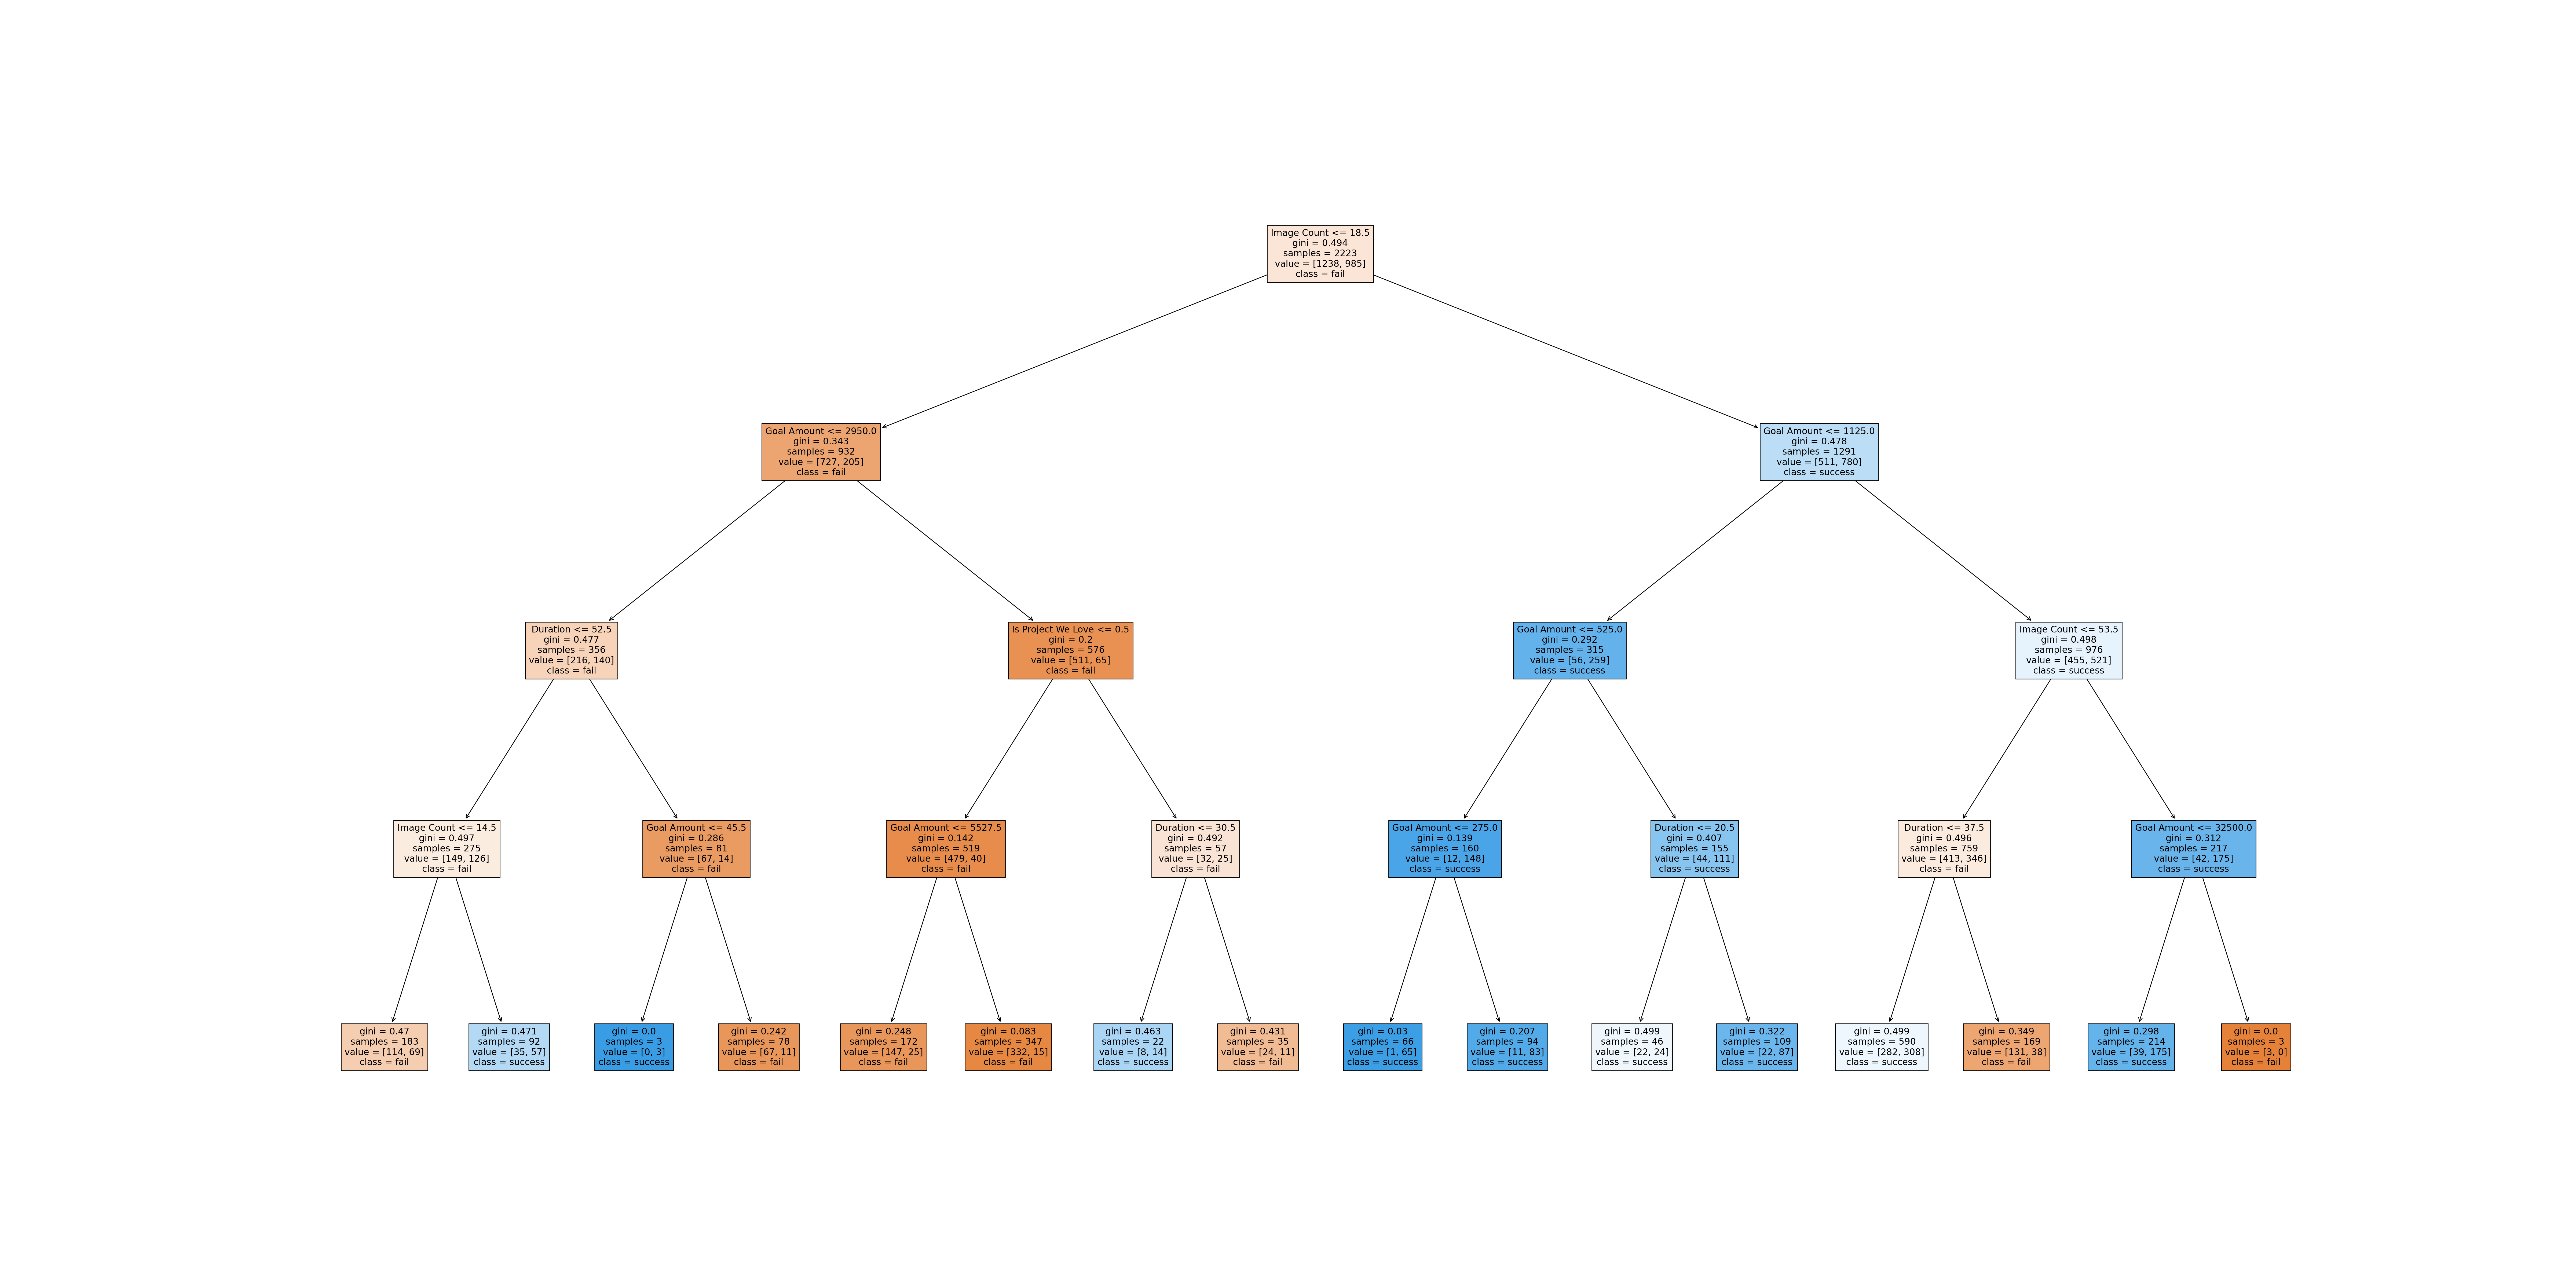

In [48]:
run_improved_decision_tree_model();

# Conclusion

להוסיף טקסט